# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

In this case we will be focusing on the FOMC announcements using the survey estimate

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")
from EventDrivenSignalGenerator import EventDrivenSignalGenerator

## Prep Data

In [15]:
def get_tsy() -> pd.DataFrame: 
    
    df_tsy = (EventDrivenSignalGenerator().get_tsy_futures().rename(
        columns = {"security": "variable"}).
        assign(variable = lambda x: x.variable.str.split(" ").str[0]))
    
    return df_tsy

def get_tsy_window(df_tsy: pd.DataFrame, before: int = -6, after: int = 1) -> pd.DataFrame:
    
    df_out = (EventDrivenSignalGenerator().get_ordered_window(
        df     = df_tsy,
        before = before,
        after  = after))
    
    return df_out

def get_estimate() -> pd.DataFrame: 
    
    df_estimate = EventDrivenSignalGenerator().get_fed_survery_estimate()

    df_tmp = (df_window.query(
        "day == 0")
        [["date", "event"]].
        drop_duplicates().
        merge(right = df_estimate, how = "inner", on = ["date"]))
    
    return df_tmp


df_tsy      = get_tsy()
df_window   = get_tsy_window(df_tsy)
df_estimate = get_estimate()

## Naive Estiamtor Strategy

In [33]:
def get_estimate_rtn(df_estimate: pd.DataFrame, df_window: pd.DataFrame) -> pd.DataFrame: 

    df_estimate_rtn = (df_estimate[
        ["event", "variable", "result_outcome"]].
        assign(namer = lambda x: x.variable.str.split("_").str[1].str.capitalize() + " Estimate (Result: " + x.result_outcome + ")").
        drop(columns = ["result_outcome", "variable"]).
        merge(right = df_window, how = "inner", on = ["event"])
        [["namer", "variable", "PX_bps", "day"]].
        groupby(["namer", "variable", "day"]).
        agg("mean").
        reset_index())
    
    return df_estimate_rtn

df_estimate_rtn = get_estimate_rtn(df_estimate, df_window)

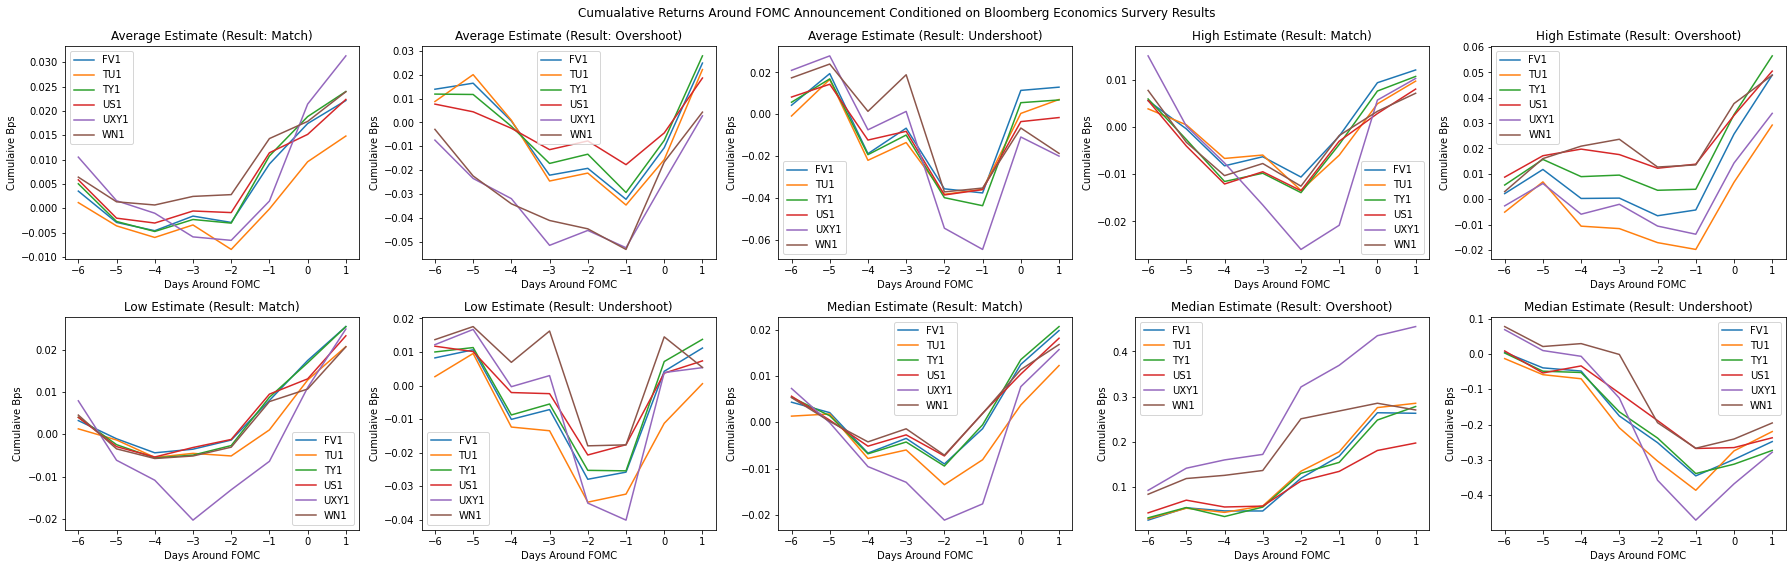

In [53]:
def plot_estimate_rtn(df_estimate_rtn: pd.DataFrame) -> plt.Figure: 
    
    namers    = df_estimate_rtn.namer.drop_duplicates().sort_values()
    fig, axes = plt.subplots(ncols = len(namers) // 2, nrows = len(namers) // 5, figsize = (25,8))

    for namer, ax in zip(namers, axes.flatten()): 

        (df_estimate_rtn.query(
            "namer == @namer").
            drop(columns = ["namer"]).
            rename(columns = {"variable": ""}).
            pivot(index = "day", columns = "", values = "PX_bps").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulaive Bps",
                xlabel = "Days Around FOMC",
                title  = namer))

    fig.suptitle("Cumualative Returns Around FOMC Announcement Conditioned on Bloomberg Economics Survery Results")
    plt.tight_layout()
    
plot_estimate_rtn(df_estimate_rtn)

Now plot the returns per each strategy, seperate strategies per each estimate group

In [134]:
def get_rtn_conditioned_estimate_rtn(
    df_estimate: pd.DataFrame, 
    df_window  : pd.DataFrame,
    start_trade: int = -3,
    end_trade  : int = -1) -> pd.DataFrame:
    
    df_tmp = (df_estimate[
        ["event", "variable", "result_outcome"]].
        rename(columns = {"variable": "estimate_group"}).
        merge(right = df_window, how = "inner", on = ["event"]).
        query("@start_trade <= day <= @end_trade").
        assign(signal_rtn = lambda x: np.where(x.result_outcome == "Undershoot", -1 * x.PX_bps, x.PX_bps))
        [["estimate_group", "signal_rtn", "variable", "date"]])
    
    return df_tmp

df_estimate_condition_rtn = get_rtn_conditioned_estimate_rtn(df_estimate, df_window)

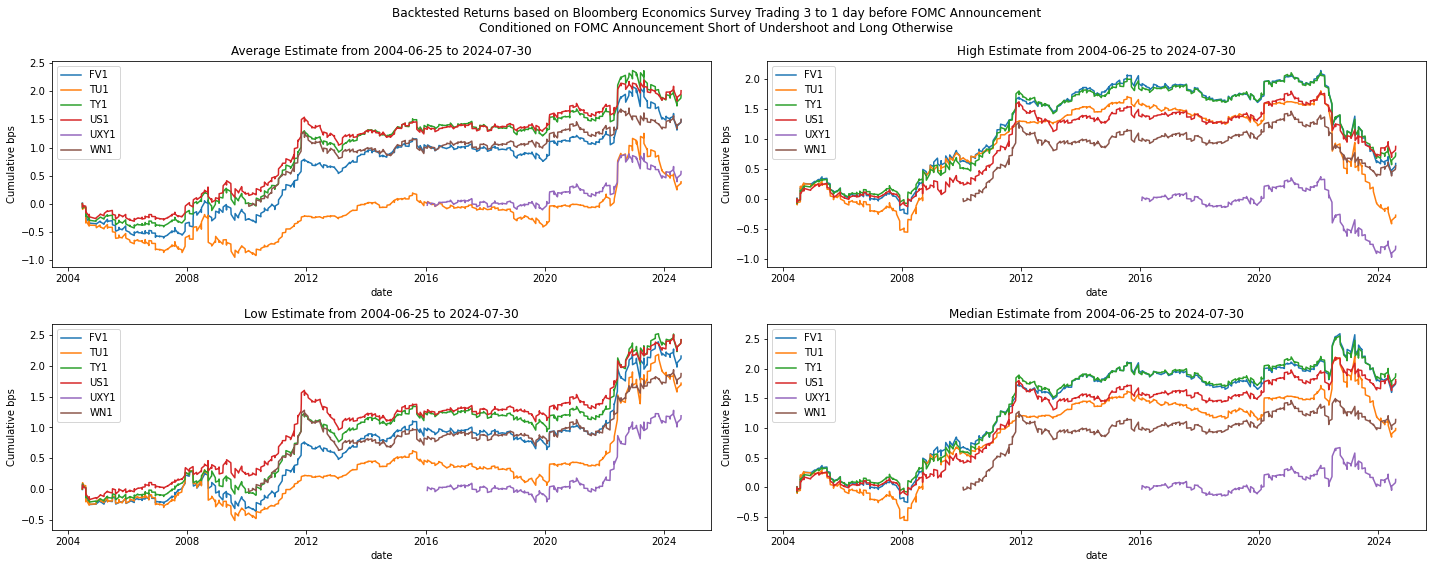

In [99]:
def plot_backtest_conditioned_estimate_rtn(df_estimate_condition_rtn: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "bn_low": "Low Estimate",
        "bn_high": "High Estimate",
        "bn_median": "Median Estimate",
        "bn_average": "Average Estimate"}

    estimate_groups = df_estimate_condition_rtn.estimate_group.drop_duplicates().sort_values().to_list()
    fig, axes       = plt.subplots(ncols = len(estimate_groups) // 2, nrows = len(estimate_groups) // 2, figsize = (20,8))

    for estimate_group, ax in zip(estimate_groups, axes.flatten()):

        df_tmp = (df_estimate_condition_rtn.query(
            "estimate_group == @estimate_group").
            drop(columns = ["estimate_group"]).
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            cumsum())

        (df_tmp.plot(
            ax     = ax, 
            ylabel = "Cumulative bps",
            title  = "{} from {} to {}".format(
                renamer[estimate_group],
                df_tmp.index.min(),
                df_tmp.index.max())))

    fig.suptitle("Backtested Returns based on Bloomberg Economics Survey Trading 3 to 1 day before FOMC Announcement\nConditioned on FOMC Announcement Short of Undershoot and Long Otherwise")
    plt.tight_layout()
    
plot_backtest_conditioned_estimate_rtn(df_estimate_condition_rtn)

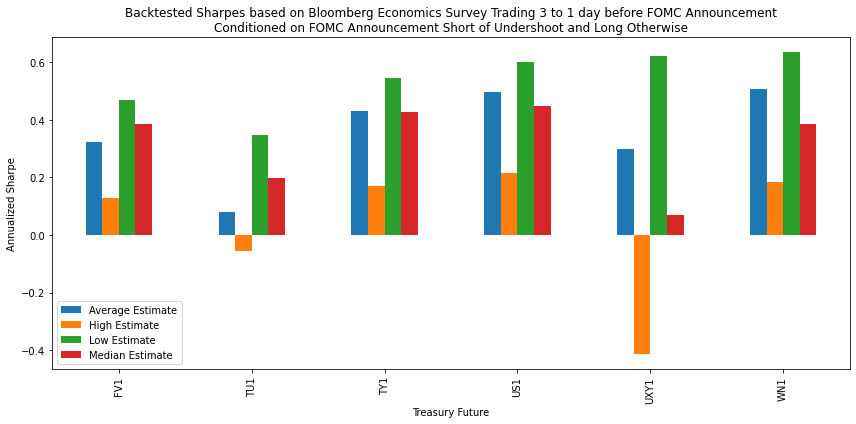

In [114]:
def plot_backtest_conditioned_estimate_sharpe(df_estimate_condition_rtn: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "bn_low": "Low Estimate",
        "bn_high": "High Estimate",
        "bn_median": "Median Estimate",
        "bn_average": "Average Estimate"}

    (df_estimate_condition_rtn.drop(
        columns = ["date"]).
        groupby(["variable", "estimate_group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(4 * 8))
        [["sharpe"]].
        reset_index().
        rename(columns = {"estimate_group": ""}).
        pivot(index = "variable", columns = "", values = "sharpe").
        rename(columns = renamer).
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            xlabel  = "Treasury Future",
            figsize = (12,6),
            title   = "Backtested Sharpes based on Bloomberg Economics Survey Trading 3 to 1 day before FOMC Announcement\nConditioned on FOMC Announcement Short of Undershoot and Long Otherwise"))
    
    plt.tight_layout()
    
plot_backtest_conditioned_estimate_sharpe(df_estimate_condition_rtn)

## Using Estimate Hike and Cut from the Estimate

The previous case examined the results based on the outcome of the result in this scenario imply what the rate outcome is and then backtest the results.

In [131]:
def get_predicted_rate(df_estimate: pd.DataFrame) -> pd.DataFrame: 
    
    df_renamer = (pd.DataFrame({
        "est_resid_sign": [-1, 0, 1],
        "est_outcome"   : ["Cut", "Hold", "Hike"]}))

    df_predict = (df_estimate[
        ["date", "actual"]].
        drop_duplicates().
        assign(prev_rate = lambda x: x.actual.shift()).
        drop(columns = ["actual"]).
        dropna().
        merge(right = df_estimate, how = "inner", on = ["date"])
        [["date", "prev_rate", "event", "predicted", "variable"]].
        assign(
            est_resid      = lambda x: x.predicted - x.prev_rate,
            est_resid_sign = lambda x: np.sign(x.est_resid)).
        merge(right = df_renamer, how = "inner", on = ["est_resid_sign"]).
        drop(columns = ["est_resid_sign"]))
    
    return df_predict

df_predict = get_predicted_rate(df_estimate)

In [148]:
def get_est_rtn(
    df_window  : pd.DataFrame, 
    df_predict : pd.DataFrame,
    start_trade: int = -3, 
    end_trade  : int = -1) -> pd.DataFrame: 

    df_est_rtn = (df_window[
        ["date", "variable", "PX_bps", "event", "day"]].
        rename(columns = {"variable": "security"}).
        query("@start_trade <= day <= @end_trade").
        merge(right = df_predict.drop(columns = ["date"]), how = "inner", on = ["event"]).
        assign(signal_rtn = lambda x: np.where(x.est_outcome == "Hike", -1 * x.PX_bps, x.PX_bps)))
    
    return df_est_rtn

df_est_rtn = get_est_rtn(df_window, df_predict)

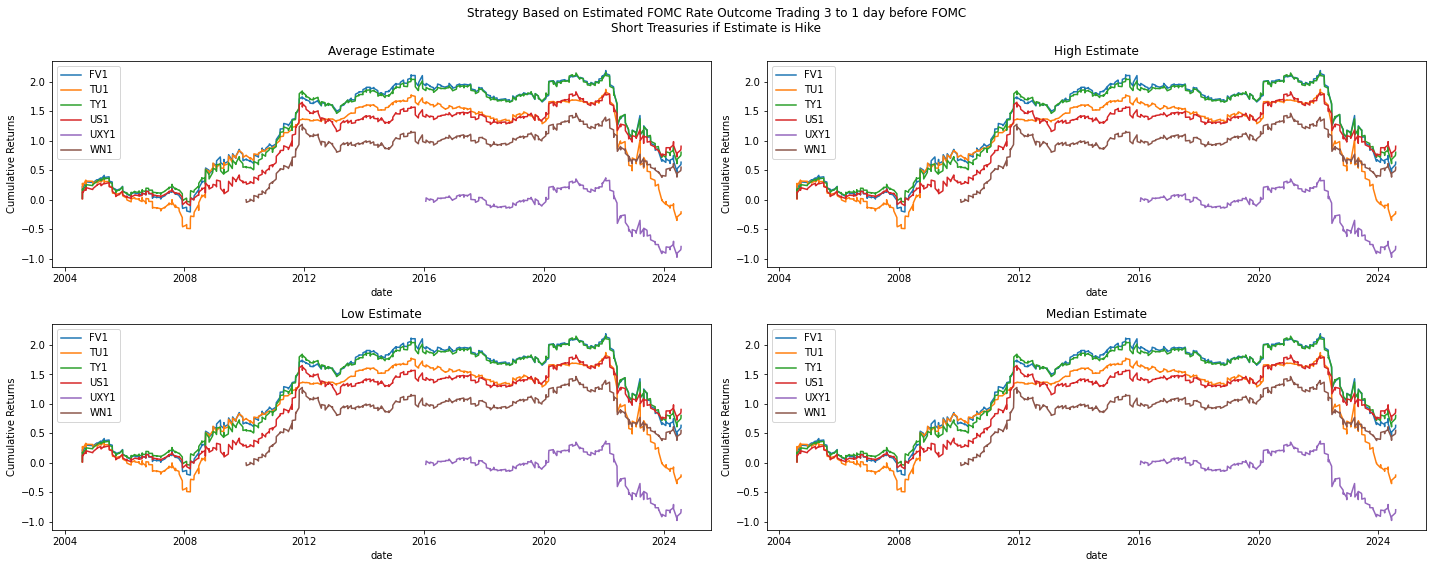

In [165]:
def plot_est_backtest(df_est_rtn: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "bn_low"    : "Low Estimate",
        "bn_high"   : "High Estimate",
        "bn_median" : "Median Estimate",
        "bn_average": "Average Estimate"}

    variables = df_est_rtn.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (20,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_est_rtn.query(
            "variable == @variable")
            [["date", "PX_bps", "security"]].
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "PX_bps").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulative Returns",
                title  = renamer[variable]))

    fig.suptitle("Strategy Based on Estimated FOMC Rate Outcome Trading 3 to 1 day before FOMC\nShort Treasuries if Estimate is Hike")
    plt.tight_layout()
    
plot_est_backtest(df_est_rtn)

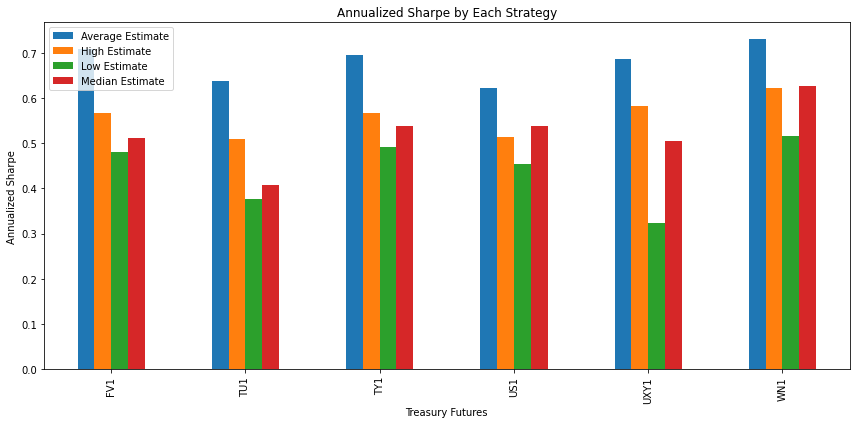

In [189]:
def plot_est_sharpes(df_est_rtn: pd.DataFrame) -> plt.Figure:
    
    (df_est_rtn[
        ["security", "variable", "signal_rtn"]].
        groupby(["security", "variable"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8 * 3)).
        reset_index()
        [["security", "variable", "sharpe"]].
        assign(variable = lambda x: x.variable.str.split("_").str[1].str.capitalize() + " Estimate").
        rename(columns = {"variable": ""}).
        pivot(index = "security", columns = "", values = "sharpe").
        plot(
            figsize = (12,6),
            kind    = "bar",
            xlabel  = "Treasury Futures",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe by Each Strategy"))

    plt.tight_layout()
    
plot_est_sharpes(df_est_rtn)